# Enrichment Analysis on LCI Predictions

Analyzes the enrichment of proteins predicted by LCI

In [111]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import goatools
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy


from dpp.methods.lci.lci_method import LCIModule
from dpp.data.network import PPINetwork
from dpp.util import Params, prepare_sns, load_mapping
from dpp.data.associations import load_diseases

prepare_sns(sns, {})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data
Load disease associations and protein-protein interaction network.

In [11]:
# load diseases
diseases_dict = load_diseases("../data/associations/disgenet-associations.csv", exclude_splits=['none'])

In [12]:
# load network
network = PPINetwork("../data/networks/bio-pathways-network.txt")
n = len(network)

In [115]:
# load entrez mapping
symbol_to_entrez = load_mapping("../data/protein/symbol_to_entrez.txt", "\t")
entrez_to_symbol = {int(entrez): symbol for symbol, entrez in symbol_to_entrez.items() if entrez!=""}
entrez_to_symbol

{1: 'A1BG',
 503538: 'A1BG-AS1',
 29974: 'A1CF',
 2: 'A2M',
 144571: 'A2M-AS1',
 144568: 'A2ML1',
 100874108: 'A2ML1-AS1',
 106478979: 'A2ML1-AS2',
 3: 'A2MP1',
 127550: 'A3GALT2',
 53947: 'A4GALT',
 51146: 'A4GNT',
 8086: 'AAAS',
 65985: 'AACS',
 729522: 'AACSP1',
 13: 'AADAC',
 344752: 'AADACL2',
 101928142: 'AADACL2-AS1',
 126767: 'AADACL3',
 343066: 'AADACL4',
 201651: 'AADACP1',
 51166: 'AADAT',
 195827: 'AAED1',
 79719: 'AAGAB',
 22848: 'AAK1',
 28971: 'AAMDC',
 14: 'AAMP',
 15: 'AANAT',
 25980: 'AAR2',
 441376: 'AARD',
 16: 'AARS',
 57505: 'AARS2',
 80755: 'AARSD1',
 106480683: 'AARSP1',
 132949: 'AASDH',
 60496: 'AASDHPPT',
 10157: 'AASS',
 284837: 'AATBC',
 26574: 'AATF',
 9625: 'AATK',
 17: 'AAVS1',
 103021294: 'ABALON',
 18: 'ABAT',
 19: 'ABCA1',
 20: 'ABCA2',
 21: 'ABCA3',
 24: 'ABCA4',
 23461: 'ABCA5',
 23460: 'ABCA6',
 10347: 'ABCA7',
 10351: 'ABCA8',
 10350: 'ABCA9',
 104355297: 'ABCA9-AS1',
 10349: 'ABCA10',
 79963: 'ABCA11P',
 26154: 'ABCA12',
 154664: 'ABCA13',
 65065

## Load Predictions
Load predictions from a disease protein prediction method.

In [13]:
predictions= pd.read_csv("../experiments/dpp_predict/lci/predictions.csv", index_col=0)

## Load Enrichment Analysis
Prepare an enrichment study

In [14]:
# load gene ontology
obodag = GODag("../data/go/go-basic.obo")

../data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms


In [15]:
geneid2go = read_ncbi_gene2go("../data/go/gene2go.txt", taxids=[9606])

  20,385 items READ: ../data/go/gene2go.txt


In [16]:
goeaobj = GOEnrichmentStudy(network.get_proteins(), # List of mouse protein-coding genes
                            geneid2go, # geneid/GO associations
                            obodag, # Ontologies
                            propagate_counts = True,
                            alpha = 0.05, # default significance cut-off
                            methods = ['fdr_bh']) # defult multipletest correction method

fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


 76% 16,420 of 21,557 population items found in association


## Perform Enrichment Analysis
Perform an enrichment analysis on one disease. 

In [225]:
disease_id = "C0398623"
disease_proteins = set(diseases_dict[disease_id].proteins)
disease_symbols = [entrez_to_symbol[entrez] for entrez in disease_proteins if entrez in entrez_to_symbol]
symbols_str=str(disease_symbols).replace('\'', '')
print(f"{diseases_dict[disease_id].name}: {symbols_str}")
sorted_predictions = predictions.loc[disease_id].sort_values(ascending=False).index
print_list([entrez_to_symbol[int(entrez)] for entrez in sorted_predictions[:7] if int(entrez) in entrez_to_symbol])

Thrombophilia: [FGA, MYD88, HRG, PLAT, THBD, HABP2, SERPINA10, PIGA, F2, F5, MTHFR, F8, F9, SERPIND1, PROC, PROS1]
(1) PROZ, (2) F2RL3, (3) GP5, (4) SERPINA5, (5) F11, (6) SERPINB6, (7) GGCX


In [216]:
# run disease enrichment
disease_results = goeaobj.run_study(disease_proteins)

100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(21557)
Calculating 21,968 uncorrected p-values using fisher_scipy_stats
  21,968 GO terms are associated with 16,420 of 21,557 population items
   1,212 GO terms are associated with     12 of     12 study items
     218 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh


In [212]:
# run prediction enrichment
pred_proteins = set(map(int, sorted_predictions[:len(disease_proteins)]))
pred_results = goeaobj.run_study(pred_proteins)

(1) IL20RA, (2) NLRP2, (3) ATM, (4) LSP1, (5) MRE11
 93%     14 of     15 study items found in association
100%     15 of     15 study items found in population(21557)
Calculating 21,968 uncorrected p-values using fisher_scipy_stats
  21,968 GO terms are associated with 16,420 of 21,557 population items
     952 GO terms are associated with     14 of     15 study items
     179 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh


In [206]:
def print_list(term_list):
    string = ""
    for i, term in enumerate(term_list):
        string += f"({i+1}) {term}, "
    print(string[:-2])

In [207]:
k = 5
disease_top_k = sorted(disease_results, key=lambda x: x.p_fdr_bh)[:k]
disease_significant = [r for r in disease_results if r.p_fdr_bh < 0.05]
print_list([result.goterm.name for result in disease_top_k])
pred_top_k = sorted(pred_results, key=lambda x: x.p_fdr_bh)[:k]
pred_significant = [r for r in pred_results if r.p_fdr_bh < 0.05]
print_list([result.goterm.name for result in pred_top_k])

(1) double-strand break repair, (2) cellular response to DNA damage stimulus, (3) DNA repair, (4) DNA metabolic process, (5) double-strand break repair via homologous recombination
(1) DNA repair, (2) DNA integrity checkpoint, (3) chromosome organization, (4) telomere maintenance, (5) positive regulation of DNA metabolic process


In [208]:
intersection = set([result.goterm.name for result in disease_top_k]) & set([result.goterm.name for result in pred_top_k])
union = set([result.goterm.name for result in disease_top_k]) | set([result.goterm.name for result in pred_top_k])
print("Jaccard Similarity: {}".format(1.0*len(intersection)/len(union)))

Jaccard Similarity: 0.1111111111111111


In [209]:
intersection = set([result.goterm.name for result in pred_significant]) & set([result.goterm.name for result in disease_significant])
union = set([result.goterm.name for result in pred_significant]) | set([result.goterm.name for result in disease_significant])

print("Jaccard Similarity: {}".format(1.0*len(intersection)/len(union)))

Jaccard Similarity: 0.36981132075471695


## Load Enrichment Results
Load enrichment study results

In [23]:
lci_results = pd.read_csv("../experiments/go_enrichment/lci/results.csv", index_col=0)
rw_results = pd.read_csv("../experiments/go_enrichment/random_walk/results.csv", index_col=0)

In [24]:
lci_eval_results = pd.read_csv("../experiments/dpp_evaluate/lci/metrics.csv", index_col=0)

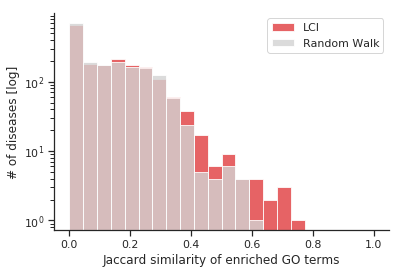

In [228]:
sns.distplot(lci_results["lci_jaccard_sim"], bins=22, kde=False, label="LCI", hist_kws={"range": (0, 1),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(rw_results["lci_jaccard_sim"], bins=22, kde=False, label="Random Walk", hist_kws={"range": (0, 1),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('log')
plt.xlabel("Jaccard similarity of enriched GO terms")
plt.ylabel("# of diseases [log]")
plt.legend()
plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

In [26]:
lci_jaccard = lci_results["lci_jaccard_sim"].sort_index()

In [27]:
lci_dpp = lci_eval_results["Recall-at-100"].sort_index()

In [37]:
pd.concat((lci_jaccard, lci_dpp), axis=1).sort_values('lci_jaccard_sim', ascending=False)

,lci_jaccard_sim,Recall-at-100
Disease ID,,
C1855020,0.754386,1.000000
C0266539,0.714286,0.300000
C2936907,0.710145,0.883333
C4021821,0.690217,0.650000
C0023520,0.655556,0.450000
C1838979,0.644737,0.850000
C1855038,0.632353,0.800000
C0009024,0.597701,0.350000
C0020555,0.591549,0.450000


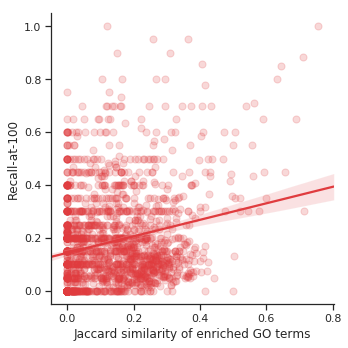

In [229]:
sns.lmplot(x='lci_jaccard_sim', y='Recall-at-100', data=pd.concat([lci_jaccard, lci_dpp], axis=1), scatter_kws={"s": 50, "alpha": 0.2})
plt.xlabel("Jaccard similarity of enriched GO terms")
plt.ylabel("Recall-at-100")



pearsonr(lci_jaccard, lci_dpp)
plt.savefig("../experiments/go_enrichment/lci/jaccard_recall_go.pdf")